In [1]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

client

/g/data/fu5/deg581/python_envs/devel3.7/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43225 instead
  f"Port {expected} is already in use.\n"


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43225/status,
Dashboard: /proxy/43225/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34709,Workers: 4
Dashboard: /proxy/43225/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.132:36757,Total threads: 4
Dashboard: /proxy/33095/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:41263,


In [3]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [44]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker
import datetime

### Load functions

In [5]:
### Other local functions

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName


def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [6]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [7]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [8]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [9]:
timeRange = [8005, 8137]
datelist = np.array(range(timeRange[0],timeRange[1],4))


In [10]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

In [11]:
def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist


filelistTruth=generateFileList(hisTruthFilePath,prefixTruth,datelist)
filelist_SSHSST=generateFileList(hisOSSEFilePath1,prefixAnalysis,datelist)
filelist_SSHSST_XBT=generateFileList(hisOSSEFilePath2,prefixAnalysis,datelist)
filelist_SSHSST_XBT_N=generateFileList(hisOSSEFilePath3,prefixAnalysis,datelist)
filelist_SSHSST_XBT_S=generateFileList(hisOSSEFilePath4,prefixAnalysis,datelist)

truth=loadOverlappedNetcdfFileList(hisTruthFilePath,prefixTruth,filelist=filelistTruth,overlapDays=7)
OSSE_SSHSST=loadOSSEFileList(hisOSSEFilePath1,prefixAnalysis, filelist=filelist_SSHSST,overlapDays=7)
OSSE_SSHSST_XBT=loadOSSEFileList(hisOSSEFilePath2,prefixAnalysis, filelist=filelist_SSHSST_XBT,overlapDays=7)
OSSE_SSHSST_XBT_N=loadOSSEFileList(hisOSSEFilePath3,prefixAnalysis, filelist=filelist_SSHSST_XBT_N,overlapDays=7)
OSSE_SSHSST_XBT_S=loadOSSEFileList(hisOSSEFilePath4,prefixAnalysis, filelist=filelist_SSHSST_XBT_S,overlapDays=7)

loaded from /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08005.nc to /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08133.nc
loaded from /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08005.nc to /g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/roms_fwd_outer1_08133.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT/output/roms_fwd_outer1_08133.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/roms_fwd_outer1_08133.nc
loaded from /g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/roms_fwd_outer1_08005.nc to /g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/roms_fwd_outer1_08133.nc


In [12]:
# process into more useful format
truth = processROMSGrid(truth)
OSSE_SSHSST=processROMSGrid(OSSE_SSHSST)
OSSE_SSHSST_XBT=processROMSGrid(OSSE_SSHSST_XBT)
OSSE_SSHSST_XBT_N=processROMSGrid(OSSE_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S=processROMSGrid(OSSE_SSHSST_XBT_S)

In [13]:
grid = makeROMSGridObject(truth)

## mean metric analysis

In [14]:
# make time series of vol/heat transport

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

transectEta = 270

truth_v_trans_N = calc_volTrans(truth,transectEta,-0.05,-2000,155)
SSHSST_v_trans_N= calc_volTrans(OSSE_SSHSST,transectEta,-0.05,-2000,155)
SSHSST_XBT_N_v_trans_N= calc_volTrans(OSSE_SSHSST_XBT_N,transectEta,-0.05,-2000,155)
SSHSST_XBT_S_v_trans_N= calc_volTrans(OSSE_SSHSST_XBT_S,transectEta,-0.05,-2000,155)
SSHSST_XBT_v_trans_N= calc_volTrans(OSSE_SSHSST_XBT,transectEta,-0.05,-2000,155)

transectEta = 170

truth_v_trans_S = calc_volTrans(truth,transectEta,-0.05,-2000,155)
SSHSST_v_trans_S= calc_volTrans(OSSE_SSHSST,transectEta,-0.05,-2000,155)
SSHSST_XBT_N_v_trans_S= calc_volTrans(OSSE_SSHSST_XBT_N,transectEta,-0.05,-2000,155)
SSHSST_XBT_S_v_trans_S= calc_volTrans(OSSE_SSHSST_XBT_S,transectEta,-0.05,-2000,155)
SSHSST_XBT_v_trans_S= calc_volTrans(OSSE_SSHSST_XBT,transectEta,-0.05,-2000,155)


In [15]:

def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean


EKE_truth = calc_timeMeanEKE(truth)
EKE_SSHSST = calc_timeMeanEKE(OSSE_SSHSST)
EKE_SSHSST_XBT_N = calc_timeMeanEKE(OSSE_SSHSST_XBT_N)
EKE_SSHSST_XBT_S = calc_timeMeanEKE(OSSE_SSHSST_XBT_S)
EKE_SSHSST_XBT = calc_timeMeanEKE(OSSE_SSHSST_XBT)


In [29]:
# load all timeseries to local memory

truth_v_trans_N.load()
SSHSST_v_trans_N.load()
SSHSST_XBT_N_v_trans_N.load()
SSHSST_XBT_S_v_trans_N.load()
SSHSST_XBT_v_trans_N.load()

truth_v_trans_S.load()
SSHSST_v_trans_S.load()
SSHSST_XBT_N_v_trans_S.load()
SSHSST_XBT_S_v_trans_S.load()
SSHSST_XBT_v_trans_S.load()

EKE_truth.load()
EKE_SSHSST.load()
EKE_SSHSST_XBT_N.load()
EKE_SSHSST_XBT_S.load()
EKE_SSHSST_XBT.load()

<xarray.DataArray (ocean_time: 792)>
array([0.06174027, 0.07562999, 0.07086239, 0.05950763, 0.05622716,
       0.05929269, 0.06308079, 0.06207919, 0.05700977, 0.05710744,
       0.05909358, 0.05926351, 0.05867847, 0.06136781, 0.06283842,
       0.06129957, 0.05933258, 0.05843806, 0.0591573 , 0.0623104 ,
       0.06487033, 0.06527067, 0.06110086, 0.05524419, 0.06184218,
       0.06307978, 0.06481217, 0.06337822, 0.05970813, 0.05700071,
       0.05959027, 0.0641964 , 0.06296261, 0.05876298, 0.05673135,
       0.05791362, 0.06126418, 0.06161701, 0.05845164, 0.05771121,
       0.06082397, 0.06417445, 0.06564244, 0.06188859, 0.05901402,
       0.06042169, 0.06153174, 0.06002378, 0.06697355, 0.06547266,
       0.06314281, 0.06209375, 0.06709638, 0.07193105, 0.07468925,
       0.07083947, 0.06408451, 0.06103989, 0.06336688, 0.06851692,
       0.07457203, 0.07461512, 0.06741653, 0.0615006 , 0.06318323,
       0.07251251, 0.07960657, 0.07702884, 0.06860024, 0.06475585,
       0.06778412, 0.0722069 , 0.08754845, 0.08780562, 0.08235292,
       0.07433237, 0.07223246, 0.07295085, 0.07847476, 0.07941438,
       0.0721617 , 0.06765097, 0.06621952, 0.06546861, 0.06969572,
       0.07379487, 0.07023523, 0.06416007, 0.06083742, 0.06270821,
       0.07096518, 0.07626524, 0.07098738, 0.06304079, 0.06224132,
       0.06716578, 0.09061452, 0.08073257, 0.06905823, 0.0684119 ,
...
       0.07027722, 0.07577328, 0.07539006, 0.07095936, 0.06946273,
       0.06972502, 0.06812701, 0.06859834, 0.0712803 , 0.07173064,
       0.06969237, 0.06673773, 0.06589249, 0.06906207, 0.07274292,
       0.07243819, 0.07140339, 0.06933658, 0.06832345, 0.07162174,
       0.07673478, 0.07701765, 0.07334862, 0.06895853, 0.06893899,
       0.06831325, 0.07774171, 0.07635817, 0.06968236, 0.06582179,
       0.06698611, 0.07158505, 0.07640299, 0.07571905, 0.07172276,
       0.06659058, 0.06507773, 0.06875114, 0.07321131, 0.07293724,
       0.06993305, 0.06568146, 0.06483962, 0.07059537, 0.07575081,
       0.07191698, 0.0678445 , 0.06657184, 0.06648393, 0.069413  ,
       0.07134823, 0.07288212, 0.07225493, 0.06792714, 0.06447093,
       0.06453062, 0.06861199, 0.07027791, 0.06795641, 0.06433502,
       0.06268264, 0.06429466, 0.06676869, 0.06737369, 0.06729303,
       0.06791693, 0.07360243, 0.07780577, 0.07298642, 0.06815064,
       0.06484435, 0.06444758, 0.06447243, 0.0720011 , 0.0690724 ,
       0.06852296, 0.07496279, 0.07841145, 0.08241554, 0.08254076,
       0.07571311, 0.07009679, 0.06979521, 0.07434905, 0.07868325,
       0.08133743, 0.07979971, 0.07905518, 0.07840002, 0.07621529,
       0.0737817 , 0.07174562, 0.070249  , 0.07107516, 0.07288629,
       0.0717878 , 0.06951296])
Coordinates:
    s_rho       float64 -0.004799
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-02 ... 2012-04-11T20:00:00

(array([15329., 15333., 15337., 15340., 15344., 15348., 15352.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 432x288 with 0 Axes>

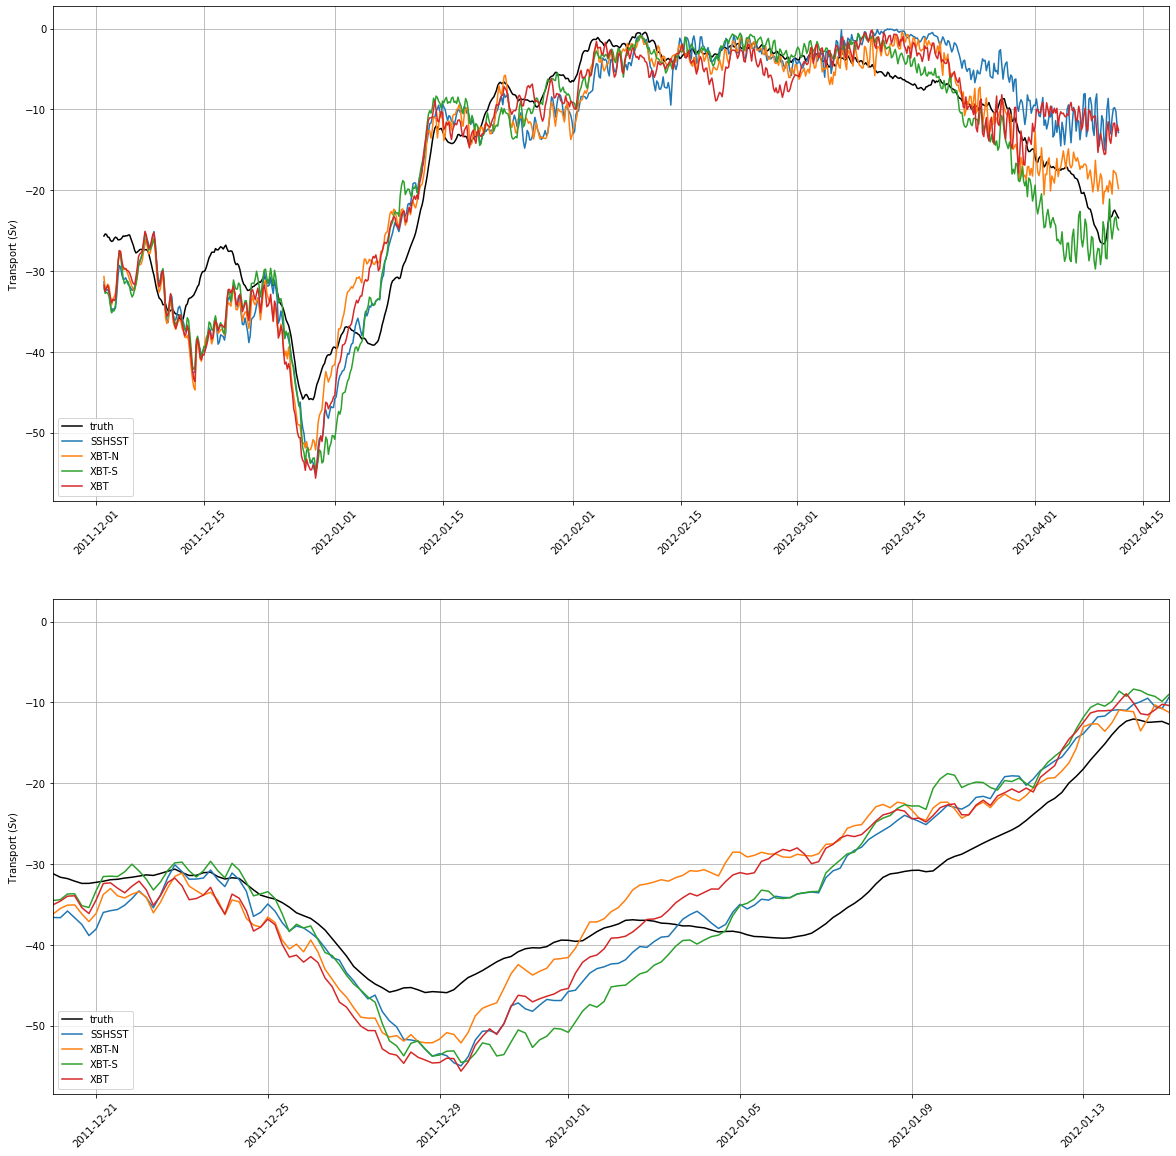

In [46]:
gs = gridspec.GridSpec(nrows=2,ncols=1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[20,20])
ax = None

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(truth.ocean_time,truth_v_trans_N/1e6,color='k',label='truth')
ax1.plot(OSSE_SSHSST.ocean_time,SSHSST_v_trans_N/1e6,label='SSHSST')
ax1.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_N_v_trans_N/1e6,label='XBT-N')
ax1.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_S_v_trans_N/1e6,label='XBT-S')
ax1.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_v_trans_N/1e6,label='XBT')
ax1.set_ylabel('Transport ($Sv$)')
ax1.grid()
ax1.legend(loc='lower left')
plt.xticks(rotation=45)
ax2 = fig.add_subplot(gs[1,0])
ax2.plot(truth.ocean_time,truth_v_trans_N/1e6,color='k',label='truth')
ax2.plot(OSSE_SSHSST.ocean_time,SSHSST_v_trans_N/1e6,label='SSHSST')
ax2.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_N_v_trans_N/1e6,label='XBT-N')
ax2.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_S_v_trans_N/1e6,label='XBT-S')
ax2.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_v_trans_N/1e6,label='XBT')
ax2.set_ylabel('Transport ($Sv$)')
ax2.grid()
ax2.legend(loc='lower left')
ax2.set_xlim([datetime.datetime(2011,12,20),datetime.datetime(2012,1,15)])
plt.xticks(rotation=45)

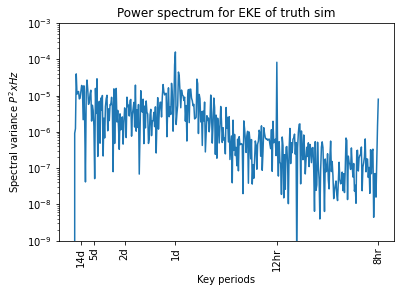

In [127]:
from scipy import signal

fs = 1/14400

EKE_t_det = signal.detrend(EKE_XBT,type='linear')

f, Pxx_den = signal.periodogram(EKE_t_det, fs)
fig,ax=plt.subplots(1)
plt.semilogy(f, Pxx_den*f)

plt.ylim([1e-9, 1e-3])
plt.xticks(np.array([8.0*60*60,12*60*60,24*60*60,48*60*60,5*24*60*60,14*24*60*60])**(-1))
ax.set_xticklabels(['8hr','12hr','1d','2d','5d','14d'])
plt.xticks(rotation=90)
plt.xlabel('Key periods')
plt.title('Power spectrum for EKE of truth sim')
plt.ylabel('Spectral variance $P^2 x Hz$')

plt.show()

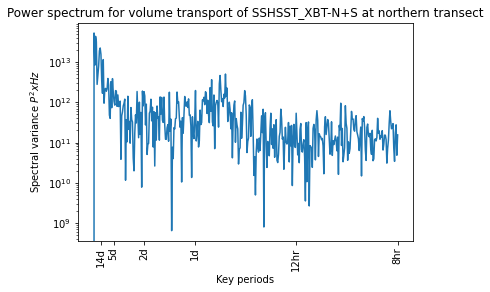

In [130]:
fs = 1/14400

SSHSST_XBT_v_trans_N_det = signal.detrend(SSHSST_XBT_v_trans_N,type='linear')

f, Pxx_den = signal.periodogram(SSHSST_XBT_v_trans_N_det, fs)
fig,ax=plt.subplots(1)
plt.semilogy(f, Pxx_den*f)

# plt.ylim([1e-9, 1e-3])
plt.xticks(np.array([8.0*60*60,12*60*60,24*60*60,48*60*60,5*24*60*60,14*24*60*60])**(-1))
ax.set_xticklabels(['8hr','12hr','1d','2d','5d','14d'])
plt.xticks(rotation=90)
plt.xlabel('Key periods')

plt.ylabel('Spectral variance $P^2 x Hz$')
plt.title('Power spectrum for volume transport of SSHSST_XBT-N+S at northern transect')
plt.show()

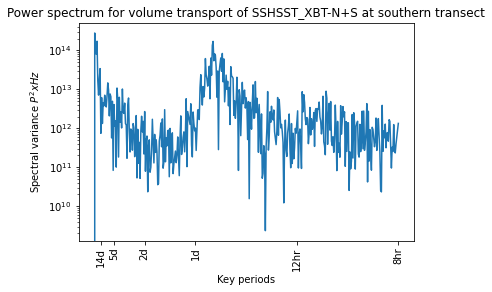

In [131]:

fs = 1/14400


SSHSST_XBT_v_trans_S_det = signal.detrend(SSHSST_XBT_v_trans_S,type='linear')

f, Pxx_den = signal.periodogram(SSHSST_XBT_v_trans_S_det, fs)
fig,ax=plt.subplots(1)
plt.semilogy(f, Pxx_den*f)

# plt.ylim([1e-9, 1e-3])
plt.xticks(np.array([8.0*60*60,12*60*60,24*60*60,48*60*60,5*24*60*60,14*24*60*60])**(-1))
ax.set_xticklabels(['8hr','12hr','1d','2d','5d','14d'])
plt.xticks(rotation=90)
plt.xlabel('Key periods')

plt.ylabel('Spectral variance $P^2 x Hz$')
plt.title('Power spectrum for volume transport of SSHSST_XBT-N+S at southern transect')
plt.show()

In [ ]:
gs = gridspec.GridSpec(nrows=3,ncols=1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,10])
ax = None

ax1 = fig.add_subplot(gs[0,0])
ax1b = ax1.twinx()
ax1.plot(truth.ocean_time,truth_v_trans_N/1e6,color='k',label='truth')
ax1b.plot(OSSE_SSHSST.ocean_time,SSHSST_v_trans_N/1e6-truth_v_trans_N/1e6,label='SSHSST')
ax1b.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_N_v_trans_N/1e6-truth_v_trans_N/1e6,label='XBT-N')
ax1b.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_S_v_trans_N/1e6-truth_v_trans_N/1e6,label='XBT-S')
ax1b.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_v_trans_N/1e6-truth_v_trans_N/1e6,label='XBT')
ax1.set_ylabel('Transport ($Sv$)')
ax1b.set_ylabel('Diff in transport ($Sv$)')
ax1.grid()
ax1.set_xticklabels('')
ax1.legend(loc='lower left')
ax1b.legend()
ax1.text(0.01, 0.99, 'a', transform=ax1.transAxes,fontsize=12, fontweight='bold', va='top')
ax1.text(0.5, 0.99, 'Volume transport at $\sim27.5^\circ S$', transform=ax1.transAxes,fontsize=12, fontweight='bold', va='top', ha='center')
ax1b.axhline(y=0, color='k', linestyle='--')
ax1.set_yticks(np.linspace(-50,5,11)),ax1.set_ylim([-50,5])
ax1b.set_yticks(np.linspace(-12,12,11)),ax1b.set_ylim([-12,12])

ax2 = fig.add_subplot(gs[1,0])
ax2b = ax2.twinx()
ax2.plot(truth.ocean_time,truth_v_trans_S/1e6,color='k',label='truth')
ax2b.plot(OSSE_SSHSST.ocean_time,SSHSST_v_trans_S/1e6-truth_v_trans_S/1e6,label='SSHSST')
ax2b.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_N_v_trans_S/1e6-truth_v_trans_S/1e6,label='XBT-N')
ax2b.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_S_v_trans_S/1e6-truth_v_trans_S/1e6,label='XBT-S')
ax2b.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_v_trans_S/1e6-truth_v_trans_S/1e6,label='XBT')
ax2.set_ylabel('Transport ($Sv$)')
ax2b.set_ylabel('Diff in transport ($Sv$)')
ax2.grid()
ax2.set_xticklabels('')
ax2.text(0.01, 0.99, 'b', transform=ax2.transAxes,fontsize=12, fontweight='bold', va='top')
ax2.text(0.5, 0.99, 'Volume transport at $\sim32^\circ S$', transform=ax2.transAxes,fontsize=12, fontweight='bold', va='top', ha='center')
ax2b.axhline(y=0, color='k', linestyle='--')
ax2.set_yticks(np.linspace(-90,-10,11)),ax2.set_ylim([-90,-10])
ax2b.set_yticks(np.linspace(-35,15,11)),ax2b.set_ylim([-35,15])


ax3 = fig.add_subplot(gs[2,0])
ax3.plot(truth.ocean_time,EKE_truth,color='k',label='truth')
ax3b=ax3.twinx()
ax3b.plot(OSSE_SSHSST.ocean_time,EKE_SSHSST-EKE_truth,label='SSHSST')
ax3b.plot(OSSE_SSHSST.ocean_time,EKE_SSHSST_XBT_N-EKE_truth,label='XBT-N')
ax3b.plot(OSSE_SSHSST.ocean_time,EKE_SSHSST_XBT_S-EKE_truth,label='XBT-S')
ax3b.plot(OSSE_SSHSST.ocean_time,EKE_SSHSST_XBT-EKE_truth,label='XBT')
ax3.set_ylabel('EKE ($m^2/s^2$)')
ax3b.set_ylabel('Diff in EKE ($m^2/s^2$)')
ax3.grid()
ax3.text(0.01, 0.99, 'c', transform=ax3.transAxes,fontsize=12, fontweight='bold', va='top')
ax3.text(0.5, 0.99, 'EKE', transform=ax3.transAxes,fontsize=12, fontweight='bold', va='top', ha='center')
ax3b.axhline(y=0, color='k', linestyle='--')
ax3.set_yticks(np.linspace(0.04,0.1,7)),ax3.set_ylim([0.04,0.1])
ax3b.set_yticks(np.linspace(-.03,0.06,7)),ax3b.set_ylim([-0.03,0.06])
plt.tight_layout()

In [ ]:
gs = gridspec.GridSpec(nrows=1,ncols=1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,4])
ax = None


ax1 = fig.add_subplot(gs[0,0])
ax1b = ax1.twinx()
ax1.plot(truth.ocean_time,truth_v_trans_N/1e6,color='k',label='truth')
ax1b.plot(OSSE_SSHSST.ocean_time,SSHSST_v_trans_N/1e6-truth_v_trans_N/1e6,label='SSHSST')
ax1b.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_N_v_trans_N/1e6-truth_v_trans_N/1e6,label='XBT-N')
ax1b.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_S_v_trans_N/1e6-truth_v_trans_N/1e6,label='XBT-S')
ax1b.plot(OSSE_SSHSST.ocean_time,SSHSST_XBT_v_trans_N/1e6-truth_v_trans_N/1e6,label='XBT')
ax1.set_ylabel('Transport ($Sv$)')
ax1b.set_ylabel('Diff in transport ($Sv$)')
ax1.grid()
ax1.set_xticklabels('')
ax1.legend(loc='lower left')
ax1b.legend()
ax1.text(0.01, 0.99, 'a', transform=ax1.transAxes,fontsize=12, fontweight='bold', va='top')
ax1.text(0.5, 0.99, 'Volume transport at $\sim27.5^\circ S$', transform=ax1.transAxes,fontsize=12, fontweight='bold', va='top', ha='center')

ax1b.axhline(y=0, color='k', linestyle='--')
ax1.set_yticks(np.linspace(-50,5,11)),ax1.set_ylim([-50,5])
ax1b.set_yticks(np.linspace(-12,12,11)),ax1b.set_ylim([-12,12])
plt.tight_layout()

In [22]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
### Now same but for 'upstream' area

etaRangeMetric = [0, 315] #[115, 200]
xiRangeMetric = [0, 270] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
ax.plot(lon_N,lat_N,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
ax.plot(lon_S,lat_S,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))



ssh_metricTruth, sst_metricTruth = compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist)

ssh_metricForecast1,ssh_metricAnalysis1 = compileOSSETimeMetricSSH(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast2,ssh_metricAnalysis2 = compileOSSETimeMetricSSH(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast3,ssh_metricAnalysis3 = compileOSSETimeMetricSSH(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast4,ssh_metricAnalysis4 = compileOSSETimeMetricSSH(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    

sst_metricForecast1,sst_metricAnalysis1 = compileOSSETimeMetricSST(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast2,sst_metricAnalysis2 = compileOSSETimeMetricSST(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast3,sst_metricAnalysis3 = compileOSSETimeMetricSST(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast4,sst_metricAnalysis4 = compileOSSETimeMetricSST(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    


fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
ssh_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

ssh_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle=      'dashed' )
ssh_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle=  'dashed' )
ssh_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
ssh_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

ssh_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle=      'solid')
ssh_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle=  'solid')
ssh_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
ssh_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    ssh_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    ssh_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    ssh_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    ssh_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    ssh_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    ssh_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    ssh_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    ssh_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    ssh_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
sst_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

sst_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle='dashed')
sst_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle='dashed')
sst_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
sst_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

sst_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle='solid')
sst_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle='solid')
sst_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
sst_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    sst_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    sst_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    sst_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    sst_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    sst_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    sst_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    sst_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    sst_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    sst_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

In [ ]:
etaRangeMetric = [270, 310] #[115, 200]
xiRangeMetric = [75, 175] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
ax.plot(lon_N,lat_N,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
ax.plot(lon_S,lat_S,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))



ssh_metricTruth, sst_metricTruth = compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist)

ssh_metricForecast1,ssh_metricAnalysis1 = compileOSSETimeMetricSSH(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast2,ssh_metricAnalysis2 = compileOSSETimeMetricSSH(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast3,ssh_metricAnalysis3 = compileOSSETimeMetricSSH(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast4,ssh_metricAnalysis4 = compileOSSETimeMetricSSH(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    

sst_metricForecast1,sst_metricAnalysis1 = compileOSSETimeMetricSST(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast2,sst_metricAnalysis2 = compileOSSETimeMetricSST(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast3,sst_metricAnalysis3 = compileOSSETimeMetricSST(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast4,sst_metricAnalysis4 = compileOSSETimeMetricSST(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    


fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
ssh_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

ssh_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle=      'dashed' )
ssh_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle=  'dashed' )
ssh_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
ssh_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

ssh_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle=      'solid')
ssh_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle=  'solid')
ssh_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
ssh_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    ssh_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    ssh_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    ssh_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    ssh_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    ssh_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    ssh_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    ssh_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    ssh_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    ssh_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
sst_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

sst_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle='dashed')
sst_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle='dashed')
sst_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
sst_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

sst_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle='solid')
sst_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle='solid')
sst_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
sst_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    sst_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    sst_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    sst_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    sst_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    sst_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    sst_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    sst_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    sst_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    sst_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

In [ ]:
etaRangeMetric = [70, 185] #[115, 200]
xiRangeMetric = [105, 185] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
ax.plot(lon_N,lat_N,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
ax.plot(lon_S,lat_S,linestyle='none',marker='.',color='xkcd:marigold',markersize=0.5)
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))



ssh_metricTruth, sst_metricTruth = compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist)

ssh_metricForecast1,ssh_metricAnalysis1 = compileOSSETimeMetricSSH(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast2,ssh_metricAnalysis2 = compileOSSETimeMetricSSH(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast3,ssh_metricAnalysis3 = compileOSSETimeMetricSSH(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
ssh_metricForecast4,ssh_metricAnalysis4 = compileOSSETimeMetricSSH(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    

sst_metricForecast1,sst_metricAnalysis1 = compileOSSETimeMetricSST(hisOSSEFilePath1,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast2,sst_metricAnalysis2 = compileOSSETimeMetricSST(hisOSSEFilePath2,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast3,sst_metricAnalysis3 = compileOSSETimeMetricSST(hisOSSEFilePath3,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    
sst_metricForecast4,sst_metricAnalysis4 = compileOSSETimeMetricSST(hisOSSEFilePath4,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist)    


fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
ssh_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

ssh_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle=      'dashed' )
ssh_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle=  'dashed' )
ssh_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
ssh_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

ssh_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle=      'solid')
ssh_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle=  'solid')
ssh_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
ssh_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    ssh_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    ssh_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    ssh_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    ssh_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    ssh_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    ssh_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    ssh_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    ssh_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    ssh_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

fig = plt.figure(figsize=(20,8))
assimPeriod = datelist
sst_metricTruth[str(assimPeriod[0])].plot.line("C0",label='Truth',linewidth=2)

sst_metricForecast1[str(assimPeriod[0])].plot.line("C1",label='Forecast SSH+SST',linestyle='dashed')
sst_metricForecast2[str(assimPeriod[0])].plot.line("C2",label='Forecast SSH+SST+XBT',linestyle='dashed')
sst_metricForecast3[str(assimPeriod[0])].plot.line("C3",label='Forecast SSH+SST+XBT_N',linestyle='dashed' )
sst_metricForecast4[str(assimPeriod[0])].plot.line("C4",label='Forecast SSH+SST+XBT_S',linestyle='dashed' )

sst_metricAnalysis1[str(assimPeriod[0])].plot.line("C1",label='Analysis SSH+SST',linestyle='solid')
sst_metricAnalysis2[str(assimPeriod[0])].plot.line("C2",label='Analysis SSH+SST+XBT',linestyle='solid')
sst_metricAnalysis3[str(assimPeriod[0])].plot.line("C3",label='Analysis SSH+SST+XBT_N',linestyle='solid')
sst_metricAnalysis4[str(assimPeriod[0])].plot.line("C4",label='Analysis SSH+SST+XBT_S',linestyle='solid')

for assimPeriod in datelist[1:]:
    sst_metricForecast1[str(assimPeriod)].plot.line("C1",label='',linestyle='dashed' )
    sst_metricForecast2[str(assimPeriod)].plot.line("C2",label='',linestyle='dashed')    
    sst_metricForecast3[str(assimPeriod)].plot.line("C3",label='',linestyle='dashed' )    
    sst_metricForecast4[str(assimPeriod)].plot.line("C4",label='',linestyle='dashed')
    
    sst_metricAnalysis1[str(assimPeriod)].plot.line("C1",label='',linestyle='solid' )
    sst_metricAnalysis2[str(assimPeriod)].plot.line("C2",label='',linestyle='solid')
    sst_metricAnalysis3[str(assimPeriod)].plot.line("C3",label='',linestyle='solid' )
    sst_metricAnalysis4[str(assimPeriod)].plot.line("C4",label='',linestyle='solid')
    
    sst_metricTruth[str(assimPeriod)].plot.line("C0",label='',linewidth=2)
    
plt.legend()
plt.title('mean SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

## RMS overview

In [ ]:

datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

fig, ax = plt.subplots(1,figsize=(10,5))

for dates in datelist:
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    filenameForecast1=hisOSSEFilePath1+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis1=hisOSSEFilePath1+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameForecast2=hisOSSEFilePath2+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis2=hisOSSEFilePath2+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameForecast3=hisOSSEFilePath3+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis3=hisOSSEFilePath3+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameForecast4=hisOSSEFilePath4+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis4=hisOSSEFilePath4+prefixAnalysis+'0'+str(dates)+'.nc'

    sshForecast1=xr.open_dataset(filenameForecast1).zeta.load()
    sshAnalysis1=xr.open_dataset(filenameAnalysis1).zeta.load()
    sshForecast2=xr.open_dataset(filenameForecast2).zeta.load()
    sshAnalysis2=xr.open_dataset(filenameAnalysis2).zeta.load()
    sshForecast3=xr.open_dataset(filenameForecast3).zeta.load()
    sshAnalysis3=xr.open_dataset(filenameAnalysis3).zeta.load()
    sshForecast4=xr.open_dataset(filenameForecast4).zeta.load()
    sshAnalysis4=xr.open_dataset(filenameAnalysis4).zeta.load()
    
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    Ana1_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis1-sshTruth)**2,axis=2),axis=1))
    Fore1_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast1-sshTruth)**2,axis=2),axis=1))
    Ana2_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis2-sshTruth)**2,axis=2),axis=1))
    Fore2_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast2-sshTruth)**2,axis=2),axis=1))
    Ana3_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis3-sshTruth)**2,axis=2),axis=1))
    Fore3_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast3-sshTruth)**2,axis=2),axis=1))
    Ana4_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis4-sshTruth)**2,axis=2),axis=1))
    Fore4_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast4-sshTruth)**2,axis=2),axis=1))
    
#     Ana_Fore = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshForecast)**2,axis=2),axis=1))
    time = sshForecast1.ocean_time.values
    if dates == datelist[0]:
        ax.plot(time, Fore1_Truth, color="C1",label='RMS Forecast-Truth SSH+SST',linestyle='dashed')
        ax.plot(time, Ana1_Truth, color="C1",label='RMS Analysis-Truth SSH+SST')
        ax.plot(time, Fore2_Truth, color="C2",label='RMS Forecast-Truth SSH+SST+XBT',linestyle='dashed')
        ax.plot(time, Ana2_Truth, color="C2",label='RMS Analysis-Truth SSH+SST+XBT')
        ax.plot(time, Fore3_Truth, color="C3",label='RMS Forecast-Truth SSH+SST+XBT_N',linestyle='dashed')
        ax.plot(time, Ana3_Truth, color="C3",label='RMS Analysis-Truth SSH+SST+XBT_N')
        ax.plot(time, Fore4_Truth, color="C4",label='RMS Forecast-Truth SSH+SST+XBT_S',linestyle='dashed')
        ax.plot(time, Ana4_Truth, color="C4",label='RMS Analysis-Truth SSH+SST+XBT_S')
    elif dates != datelist[0]:
        ax.plot(time, Fore1_Truth, color="C1",label='_nolegend_',linestyle='dashed')
        ax.plot(time, Ana1_Truth, color="C1",label='_nolegend_')
        ax.plot(time, Fore2_Truth, color="C2",label='_nolegend_',linestyle='dashed')
        ax.plot(time, Ana2_Truth, color="C2",label='_nolegend_')
        ax.plot(time, Fore3_Truth, color="C3",label='_nolegend_',linestyle='dashed')
        ax.plot(time, Ana3_Truth, color="C3",label='_nolegend_')
        ax.plot(time, Fore4_Truth, color="C4",label='_nolegend_',linestyle='dashed')
        ax.plot(time, Ana4_Truth, color="C4",label='_nolegend_')
        
#     ax.plot(time, Ana_Fore, color="C2",label='Truth')
ax.legend()
ax.grid()
ax.tick_params('x',labelrotation=45)


In [ ]:
timePeriod = 4  #days
timeOutputs = 1 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

rr=0
timeVec = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHobs = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHmod = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHanal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHfore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSHerror_fore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSHerror_anal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHtruth = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHfore = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHanal = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()
    
    filenameObs=obsFinalFilePath+prefixObs+str(dates)+'.nc'
    obs=xr.open_dataset(filenameObs).load()

    for tChunk in range(0,timeOutputMax,timeOutputs):
        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2)
        # print(tChunk,time1,time2,time1sd,time2sd)
        timeVec[rr]=np.nanmean([time1sd,time2sd])

        modVal = mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        obsVal = obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        modAnal = mod.NLmodel_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        modFore = mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        meanSSHobs[rr] = np.nanmean(obsVal)
        meanSSHmod[rr] = np.nanmean(obsVal)
        meanSSHanal_obsspace[rr] = np.nanmean(modAnal)
        meanSSHfore_obsspace[rr] = np.nanmean(modFore)
        rmsSSHerror_fore_obsspace[rr] = np.sqrt(((modFore - obsVal)**2).mean(dim='datum',skipna=True))
        rmsSSHerror_anal_obsspace[rr] = np.sqrt(((modAnal - obsVal)**2).mean(dim='datum',skipna=True))

        meanSSHtruth[rr] = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSHfore[rr]  = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSHanal[rr]  = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)

        rr=rr+1




In [ ]:

fig,ax = plt.subplots(1,figsize=(20,8))
ax.plot(timeVec,meanSSHtruth,linestyle='-',color="C0",label='mean SSH truth')
ax.plot(timeVec,meanSSHobs,linestyle='none',marker='o',color="C0",label='mean SSH obs')
ax.plot(timeVec,meanSSHanal,linestyle='-',color="C1",label='mean SSH analysis')
ax.plot(timeVec,meanSSHanal_obsspace,linestyle='none',marker='o',color="C1",label='mean SSH obs analysis')
ax.plot(timeVec,meanSSHfore,linestyle='-',color="C2",label='mean SSH forecast')
ax.plot(timeVec,meanSSHfore_obsspace,linestyle='none',marker='o',color="C2",label='mean SSH obs forecast')
ax.grid()
ax.legend()
ax.set_ylim([.2,.5])

In [ ]:

fig,ax = plt.subplots(1,figsize=(20,8))
ax.plot(timeVec,meanSSHtruth,linestyle='-',color="C0",label='mean SSH truth')
ax.plot(timeVec,meanSSHanal,linestyle='-',color="C1",label='mean SSH analysis')
ax.plot(datelist,np.array(0.35*np.ones([len(datelist),1])),color='C4',linestyle='none',marker='o',markersize=3)
ax.vlines(datelist, ymin=0.25, ymax=.45, colors='green', ls=':', lw=1, label='cycle borders')
ax.grid()
ax.legend()
ax.set_ylim([.2,.5])
# ax.set_xlim([8080,8120])
ax.set_title('mean SSH for truth and analysis')

In [ ]:

fig, ax = plt.subplots(1,figsize=(20,8))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    Ana_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshTruth)**2,axis=2),axis=1))
    Fore_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast-sshTruth)**2,axis=2),axis=1))
    Ana_Fore = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshForecast)**2,axis=2),axis=1))
    time = sshForecast.ocean_time.values
    if dates == datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='RMS Forecast-Truth')
        ax.plot(time, Ana_Truth, color="C1",label='RMS Analysis-Truth')
        ax.vlines(time[0], ymin=0.05, ymax=.15, colors='green', ls=':', lw=1, label='cycle borders')
    elif dates != datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='_nolegend_')
        ax.plot(time, Ana_Truth, color="C1",label='_nolegend_')
        ax.vlines(time[0], ymin=0.05, ymax=.15, colors='green', ls=':', lw=1, label='_nolegend_')

ax.legend()
ax.grid()
ax.tick_params('x',labelrotation=45)
ax.set_xlim([serial_day_to_datestring(8080),serial_day_to_datestring(8120)])

In [ ]:

fig,ax = plt.subplots(1,figsize=(10,4))
ax.plot(timeVec,rmsSSHerror_anal_obsspace,linestyle='none',marker='o',color="C1",label='RMSe SSH Analysis-Truth',markersize=2)
ax.plot(timeVec,rmsSSHerror_fore_obsspace,linestyle='none',marker='o',color="C0",label='RMSe SSH Forecast-Truth',markersize=2)
ax.grid()
ax.legend()


In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=340

rr=0
timeVec = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTobs = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTmod = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTanal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTfore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSTerror_fore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSTerror_anal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTtruth = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTfore = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTanal = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()
    
    filenameObs=obsFinalFilePath+prefixObs+str(dates)+'.nc'
    obs=xr.open_dataset(filenameObs).load()

    for tChunk in range(0,timeOutputMax,timeOutputs):
        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2)
        # print(tChunk,time1,time2,time1sd,time2sd)
        timeVec[rr]=np.nanmean([time1sd,time2sd])

        modVal = mod.obs_value.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        obsVal = obs.obs_value.where(np.isnan(mod.obs_scale)==False).where((obs.obs_provenance==provValue) & (obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        modAnal = mod.NLmodel_value.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        modFore = mod.NLmodel_initial.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        meanSSTobs[rr] = np.nanmean(obsVal)
        meanSSTmod[rr] = np.nanmean(obsVal)
        meanSSTanal_obsspace[rr] = np.nanmean(modAnal)
        meanSSTfore_obsspace[rr] = np.nanmean(modFore)
        rmsSSTerror_fore_obsspace[rr] = np.sqrt(((modFore - obsVal)**2).mean(dim='datum',skipna=True))
        rmsSSTerror_anal_obsspace[rr] = np.sqrt(((modAnal - obsVal)**2).mean(dim='datum',skipna=True))

        meanSSTtruth[rr] = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSTfore[rr]  = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSTanal[rr]  = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)

        rr=rr+1




fig,ax = plt.subplots(1,figsize=(10,4))
ax.plot(timeVec,meanSSTtruth,linestyle='-',color="C0",label='mean SST truth')
ax.plot(timeVec,meanSSTobs,linestyle='none',marker='o',color="C0",label='mean SST obs')
ax.plot(timeVec,meanSSTanal,linestyle='-',color="C1",label='mean SST analysis')
ax.plot(timeVec,meanSSTanal_obsspace,linestyle='none',marker='o',color="C1",label='mean SST obs analysis')
ax.plot(timeVec,meanSSTfore,linestyle='-',color="C2",label='mean SST forecast')
ax.plot(timeVec,meanSSTfore_obsspace,linestyle='none',marker='o',color="C2",label='mean SST obs forecast')
ax.grid()
ax.legend()
# ax.set_ylim([.2,.5])

## now plot snapshots of fields

In [ ]:
timePeriod = 4  #days
timeOutputs = 6 # 4hrlymodel output * timeOutputs = hrs per snapshot. e.g. 3(*4hrs)=12hrly outputs, 6=24hrly output
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8033] 
datelist = np.array(range(timeRange[0],timeRange[1],4))
#datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=405

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    
    for tChunk in range(0,timeOutputMax,timeOutputs):
        fig, axes = plt.subplots(1,4, figsize=(16, 4), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        toPlotData = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[0]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([-1,1])
        ax.set_title('Truth')
        
        ax = axes[1]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        ax.set_title('Obs')
        
        toPlotData = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[2]            
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        im.set_clim([-1,1])
        ax.set_title('Forecast')


        toPlotData = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[3]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False  
        gl.left_labels = False
        im.set_clim([-1,1])
        ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        fig.colorbar(im, ax=axes.ravel().tolist())
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SSH Truth, Obs Forecast and Analysis, with observations, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('m')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=340

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    
    for tChunk in range(0,timeOutputMax,timeOutputs):
        fig, axes = plt.subplots(1,4, figsize=(16, 4), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[0]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([16,28])
        ax.set_title('Truth')
        
        ax = axes[1]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title('Obs')
        
        toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[2]            
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        im.set_clim([16,28])
        ax.set_title('Forecast')


        toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[3]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False  
        gl.left_labels = False
        im.set_clim([16,28])
        ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        fig.colorbar(im, ax=axes.ravel().tolist())
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Truth, Obs Forecast and Analysis, with observations, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=405

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-.5,.5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SSH Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('m')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    # sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    # sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-5,5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(1,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        ax = axes[rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')

        lo=obs.obs_lon.where(obs.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==True).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==True).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        sc2 = ax.plot(lo,la,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)

        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        rr=rr+1
        
        #date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        #date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+str(time1)[:-13]+' to '+str(time2)[:-13])
        plt.ylabel('degC')




In [ ]:
# mod.obs_value.where(np.isnan(mod.obs_scale)==False)
for dates in datelist:
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod = xr.open_dataset(filenameMod).load()
    print('file: '+str(dates)+'. Total number of obs: '+str(len(mod.obs_value))+'. Number of rejected obs: '+str(np.count_nonzero(np.isnan(mod.obs_scale)==True))+'. Percent rejected: '+str(np.round(np.count_nonzero(np.isnan(mod.obs_scale)==True)/np.count_nonzero(np.isnan(mod.obs_scale)==False)*100,decimals=1))+'%')


In [ ]:
str(dates)+'. Total number of obs: '+str(len(mod.obs_value))+'. Number of rejected obs: '+str(np.count_nonzero(np.isnan(mod.obs_scale)==True))+'. Percent rejected: '+str(np.round(np.count_nonzero(np.isnan(mod.obs_scale)==True)/np.count_nonzero(np.isnan(mod.obs_scale)==False)*100,decimals=1))+'%'

In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    # sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    # sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-5,5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')


